In [ ]:
from Sim_File_pd import sim_pd
from Event_Builder import BuildEvts
from PipeMaker import makepipe
from ConeMaker import makecone
from NozzleMaker import makenozz
from shutil import copyfile
import numpy as np
import glob
import os
import re
import math
import fnmatch
from CircleAreaCalc import area_calc, new_height_calc
import math
import matplotlib.pyplot as plt

<img src="./Jupyter_Pics/solstise_logo.png" style="width: 700px;"/>

# **SOLSTISE Simulation Code**
Written for your enjoyment by Matt Hall (mhall12@alumni.nd.edu).

SOLSTISE is a gas jet target for use inside the SOLARIS magnet at the Facility for Rare Isotope Beams. This code will simulate the reaction kinematics and track the particles as they orbit in the magnetic field before they get detected. The reaction products will not be detected if they hit the gas jet infrastructure. This shadowing of the particles can then be assessed using various plots at the end of the code. 

The general structure of this Jupyter notebook is as follows:
1. An event file will be created using the Event_Builder.py code.
2. The jet infrastructure geometry (nozzle, receiver cone, gas return pipe) will then be set.
3. The shadowing simulation will be run, which propogates the particles through the magnetic field. 
4. Plots showing the shadowing and reaction products can be created.

Note: If this is your first time running the code, some directories will be made to contain the different files used in the simulation code. \
First, let's run the Event Builder or open a pre-made event file: 

Tip: The user can just press "Enter" on the questions asking about the magnetic field, etc to use default values.

In [2]:
if not os.path.exists("Event_Files"):
    print("An Event_Files directory was not found, so one was created for you!\n")
    os.mkdir("Event_Files")

if not os.path.exists("Output_Files"):
    print("An Output_Files directory was not found, so one was created for you!\n")
    os.mkdir("Output_Files")

if not os.path.exists("Geometry_Files"):
    print("A Geometry_Files directory was not found, so one was created for you! \n")
    os.mkdir("Geometry_Files")

evtdir = "./Event_Files/"
geodir = "./Geometry_Files/"

defnozz = ".SOLSTISE_nozz_default.txt"
defcone = ".SOLSTISE_cone_3_2-6in.txt"

if not os.path.exists(geodir + defnozz[1:]):
    copyfile(defnozz, geodir + defnozz[1:])
    print("The default nozzle file was copied to the Geometry_Files directory!")
if not os.path.exists(geodir + defcone[1:]):
    copyfile(defcone, geodir + defcone[1:])
    print("The default receiver cone file was copied to the Geometry_Files directory!")

list_files = glob.glob(evtdir + '*evts*.txt')

if len(list_files) == 0:
    print("It appears that no event files exist, so we'll create one now!")
    filein = BuildEvts()
else:
    latest_file = max(list_files, key=os.path.getctime)
    latest_file = latest_file[14:]
    print("\nThe most recently created input file is: " + latest_file)
    yn = input("\nWould you like to use this file? [Y/N] ")

    if yn == "N" or yn == "n":
        newevtfileyn = input("Would you like to generate a new event simulation file? [Y/N] ")

        if newevtfileyn == "N" or newevtfileyn == "n":
            print("\n")
            for i in range(len(list_files)):
                print(str(i+1) + ") " + list_files[i][14:])

            filenum = 1000000
            while filenum > len(list_files):
                filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                if len(list_files) >= filenum > 0:
                    filein = list_files[filenum-1][14:]
                elif filenum > len(list_files):
                    print("ERROR: Number entered is greater than the number of simulation files...")
                else:
                    list_file2 = []
                    while len(list_file2) == 0:
                        filein = input("\nEnter the name of an existing input file (.dat or .txt): ")
                        list_file2 = glob.glob(evtdir + filein)

                        if len(list_file2) == 0:
                            print("\nERROR: The file does not exist...")
        else:
            filein = BuildEvts()
    else:
        filein = latest_file
        print(filein)

print("\nThe file to be used is: " + filein)

# Get the reaction out of the file name
# the locations of the underscores in the file name are found here and put into an array
uslocs = [m.start() for m in re.finditer('_', filein)]

reac = filein[:uslocs[0]] + "(" + filein[(uslocs[0]+1):uslocs[1]] + "," + filein[(uslocs[1]+1):uslocs[2]] + ")"

print("The reaction is: " + reac)

# Get the beam energy from the file name:

ebeam = int(filein[(uslocs[2]+1):uslocs[3]])

print("The beam energy is: " + str(ebeam) + " MeV")

try:
    bfield = float(input("\nEnter the magnetic field strength in Tesla: "))
except ValueError:
    bfield = 2.0

try:
    beamdia = float(input("\nEnter the beam diameter (FWHM) to be used in the simulation in mm: "))
except ValueError:
    beamdia = 1

if not fnmatch.fnmatch(filein, '*eloss*'):
    try:
        jetrad = float(input("\nEnter the jet radius in mm (typical values are on the order of 1.0 to 1.75 mm): "))
    except ValueError:
        jetrad = 1.25
else:
    jetrad = 0

try:
    detzi = float(input("\nEnter the distance from the target that the detector array should start in m: "))
except ValueError:
    detzi = 0.2

# need to load the file into a numpy array to do genfromtxt to determine whether or not the reaction is going to be
# measured in normal or inverse kinematics, then ask which way the return pipe is facing. If the pipe is facing the
# opposite direction, we'll just skip over the pipe definition and make the radius of the pipe tiny so it doesn't
# interfere with the reaction products...

datas = np.genfromtxt(evtdir + filein)
if datas[:, 0].mean() > 90:
    invkin = 1
else:
    invkin = 0


The most recently created input file is: d_27Si_p_100_evts_allE.txt

Would you like to use this file? [Y/N] 
d_27Si_p_100_evts_allE.txt

The file to be used is: d_27Si_p_100_evts_allE.txt
The reaction is: d(27Si,p)
The beam energy is: 100 MeV

Enter the magnetic field strength in Tesla: 

Enter the beam diameter (FWHM) to be used in the simulation in mm: 

Enter the jet radius in mm (typical values are on the order of 1.0 to 1.75 mm): 

Enter the distance from the target that the detector array should start in m: 


If you created a new file, it was saved in the ./Event_Files directory. It can now be read in the rest of the code, or used later on.

Now, the geometry parameters of the jet infrastructure (nozzle, receiver cone, and pipe) need to be generated. Below is a drawing of the setup with the different components labeled. There are default option for each component, or the user can generate custom components below.

<img src="./Jupyter_Pics/SolstiseLabeledDrawing.PNG" alt="Drawing" style="width: 1000px;"/>

The first piece of the geometry we will define is the return pipe at the bottom of the solenoid. The vertical portion of the pipe directly below the receiver cone will always shadow some particles. However, if the horizontal portion of the pipe at the bottom of the solenoid is in the same half of the magnet as the detectors, some of the particles will be shadowed by this as well. In this case, to reduce the shadowing, the shape of the pipe can be altered. 

If a custom pipe is being made, we'll use a simplified geometry to mke the calculation a little easier (the below Figure is for reference). We'll define the upper boundary of the pipe as a second circle ($r_2$). The area_calc function will then calculate what the height of the 2nd circle has to be from the bottom of the bore to keep the cross-sectional area the same as an ISO-160 pipe. The code below will ask for the radius of the 2nd circle -- the larger the radius, the flatter the "pipe" will be on the top. Try starting with 3 meters and rerun the cell if you'd like to change that radius. 

In addition, you can specify the angle for the walls of the pipe. If the angle you specify is too large (i.e. the top of the new pipe would be over the height of the ISO-160 pipe), you will be asked for another angle. Since the pipe is symmetric, only one angle $\theta_1$ needs to be specified. 

<img src="./Jupyter_Pics/NewPipePic.png" alt="Drawing" style="width: 500px;"/>

Any custom pipe you create will be saved as its own pipe file, who's name is formatted PipeOut_2nd Circle radius_pipe angle.txt.

To define the pipe, run the cell below:


Is the pipe for the gas return in the downstream (0) or upstream (1) half of the magnet?: 1

Would you like to use a custom shaped pipe for the gas return? [Y/N] y

The most recently created pipe setup file is: PipeOut_5_240.txt

Would you like to use this file? [Y/N] n
Would you like to generate a new custom pipe input file? [Y/N] y

Now the SOLSTISE pipe will be defined. It is bounded by two circles of radius r1 and r2,
as well as two angles θ₁ and θ₂.

Will the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? 1


<IPython.core.display.Javascript object>


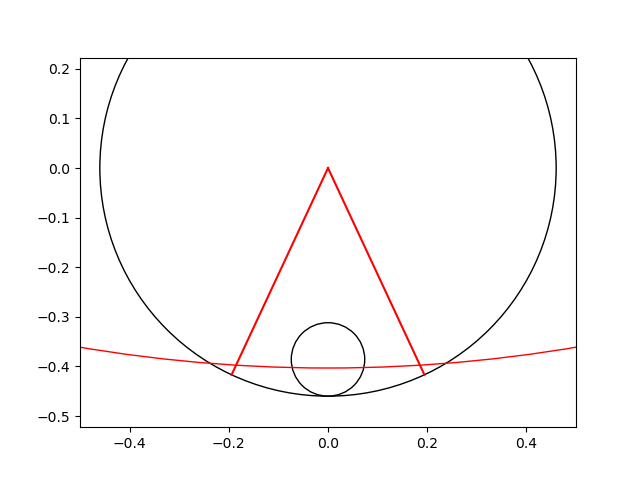

The radius is 0.46 m.

Enter the radius of the 2nd circle in meters: 3
2.59444559434628
The circle intersection points are 239 degrees and 300 degrees

Would you like to use new angles for the pipe geometry? (Y/N) y

Note: the new angle must be greater than 239 and less than 270 degrees.

 the new angle (in degrees): 245
An output file named PipeOut_3_245.txt was created!
The custom pipe you made can be viewed above!


In [6]:
### The following code is from the SOLSTISE_Sim.py and includes the PipeMaker.py code for illustration.

# Remove this question if the user is using a solid target:
newpipe = 0
if not fnmatch.fnmatch(filein, '*eloss_s*'):
    try:
        pipefb = int(input("\nIs the pipe for the gas return in the downstream (0) or upstream (1) half of the "
                           "magnet?: "))
    except ValueError:
        pipefb = 0
else:
    pipefb = 0

if pipefb != invkin:
    pipeyn = 'n'
else:
    pipeyn = input("\nWould you like to use a custom shaped pipe for the gas return? [Y/N] ")

# Below, an ISO-160 pipe at the bottom of the magnet is defined.
if pipeyn == "N" or pipeyn == "n":

    hors = 0

    while hors != 1 and hors != 2:
        try:
            hors = int(input("\nWill the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? "))
        except ValueError:
            hors = 1

        if hors != 1 and hors != 2:
            print("\nERROR: Unknown entry...")

    if hors == 1:
        r1 = 0.92 / 2
    else:
        r1 = 0.9 / 2

    if pipefb != invkin:
        piper = 0.001
        pipecenter = -r1
        phi1 = 3/2*math.pi
        phi2 = 3/2*math.pi
    else:
        piper = 0.152908/2
        pipecenter = 0.152908/2-r1
        phi1 = (180 + 90)*math.pi/180 - math.asin(piper/pipecenter)
        phi2 = 2*math.pi - (phi1 - math.pi)

else:
    list_pipe_files = glob.glob(geodir + 'PipeOut*.txt')

    if len(list_pipe_files) == 0:
        print("\nNo pipe setup file exists in your directory, so we'll make one now.")
        newpipe = 1
    else:
        latest_pipe_file = max(list_pipe_files, key=os.path.getctime)
        latest_pipe_file = latest_pipe_file[17:]
        print("\nThe most recently created pipe setup file is: " + latest_pipe_file)
        pfileyn = input("\nWould you like to use this file? [Y/N] ")
        if pfileyn == "N" or pfileyn == "n":
            pfileyn2 = input("Would you like to generate a new custom pipe input file? [Y/N] ")
            if pfileyn2 == "N" or pfileyn2 == "n":
                print("\n")
                for i in range(len(list_pipe_files)):
                    print(str(i + 1) + ") " + list_pipe_files[i][17:])

                filenum = 1000000
                while filenum > len(list_pipe_files):
                    filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                    if len(list_pipe_files) >= filenum > 0:
                        pipedeffile = list_pipe_files[filenum - 1][17:]
                    elif filenum > len(list_pipe_files):
                        print("ERROR: Number entered is greater than the number of simulation files...")
                    else:
                        list_file_check = []
                        while len(list_file_check) == 0:
                            pipedeffile = input("Enter the name of the pipe input file: ")
                            list_file_check = glob.glob(geodir + pipedeffile)
                            if len(list_file_check) == 0:
                                print("ERROR: The file does not exist...")
            else:
                newpipe = 1

if newpipe == 1:
    print("\nNow the SOLSTISE pipe will be defined. It is bounded by two circles of radius r1 and r2,")
    print("as well as two angles \u03B8\u2081 and \u03B8\u2082.")

    hors = 0

    while hors != 1 and hors != 2 and hors != 333:

        hors = int(input("\nWill the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? "))

        if hors != 1 and hors != 2 and hors != 333:
            print("\nERROR: Unknown entry...")

    # 333 is for the SOLSTISE chamber/debugging. Shhhhh it's a secret!
    if hors == 1:
        r1 = 0.92 / 2
    elif hors == 333:
        r1 = 0.376174  # 14.81 inches
    else:
        r1 = 0.9 / 2

    #plt.ion()
    %matplotlib notebook
    circle1 = plt.Circle((0, 0), r1, ec='black', color='white')

    # ISO 160 pipe dia in m
    pipedia = 5.83 * 2.54 / 100
    pipecenter = pipedia / 2 - r1
    circlepipe = plt.Circle((0, pipecenter), pipedia / 2, ec='black', fill=False)

    fig, ax = plt.subplots()
    ax.add_artist(circle1)
    ax.add_artist(circlepipe)
    ax.axis('equal')
    ax.set_xlim((-.5, .5))
    ax.set_ylim((-.7, .4))
    #fig.show()

    # matplotlib spits out some warnings and errors that can be ignored, but print the radius and require an 
    # because otherwise the error goes at the end of the next .
    print("The radius is", r1, "m.")
    r2 = float(input("\nEnter the radius of the 2nd circle in meters: "))

    if r2 == 0:
        r2in = float(input("\nEnter the radius of the 2nd circle in inches: "))
        r2 = r2in * 2.54 / 100

    ang1, h = area_calc(r1, r2)

    print(h)

    circle2 = plt.Circle((0, h), r2, ec='red', fill=False)
    plt.gcf().gca().add_artist(circle2)
    #fig.show()

    ang1deg = ang1 * 180 / math.pi

    if ang1deg > 270:
        ang1deg = 360 - (ang1deg - 180)

    ang2deg = 360 - (ang1deg - 180)

    print("The circle intersection points are", int(ang1deg), "degrees and", int(ang2deg), "degrees")
    yn2 = input("\nWould you like to use new angles for the pipe geometry? (Y/N) ")

    # for now accept only one angle, but later we'll do multiple angles.
    # anglist = []
    pipethickcheck = .15
    iso160pipedia = .148082
    c2height = 0.0
    angin = 0
    anginrad = 0
    angin2 = 0
    angin2rad = 0

    if yn2 == "N" or yn2 == "n":
        # anglist.append(ang1)
        angin = ang1deg

        anginrad = angin * math.pi / 180
        angin2 = 360 - (angin - 180)
        angin2rad = angin2 * math.pi / 180

        c2height = h

    else:
        circle2.set_visible(False)
        # It has to be less than 270 because that's the bottom of the circle. Actually, 270 is also dumb because
        # the pipe would block the entire path then.
        print("\nNote: the new angle must be greater than", int(ang1deg), "and less than 270 degrees.")

        while (angin < ang1deg or angin > 270) or pipethickcheck > iso160pipedia:
            angin = float(input("\n the new angle (in degrees): "))
            if angin < ang1deg:
                print("Error: The angle must be greater than", int(ang1deg), "and less than 270 degrees.")
            elif angin > ang1deg:
                c2height = new_height_calc(r1, r2, angin)
                pipethickcheck = r1 - r2 + c2height
                if pipethickcheck > iso160pipedia:
                    print("Error: The calculated pipe height is", pipethickcheck, "m.")
        # anglist.append(angin)

        anginrad = angin * math.pi / 180
        angin2 = 360 - (angin - 180)
        angin2rad = angin2 * math.pi / 180

        circle3 = plt.Circle((0, c2height), r2, ec='red', fill=False)
        plt.gcf().gca().add_artist(circle3)
        x1, y1 = [0, r1 * math.cos(anginrad)], [0, r1 * math.sin(anginrad)]
        x2, y2 = [0, r1 * math.cos(angin2rad)], [0, r1 * math.sin(angin2rad)]
        plt.plot(x1, y1, x2, y2, color='red')
        #input("Press Enter")

    #plt.ioff()

    fname = "PipeOut_" + str(int(r2)) + "_" + str(int(angin)) + ".txt"

    params = [r1, r2, c2height, anginrad, angin2rad]

    # ("\nPress ENTER to continue.")

    geodir = "./Geometry_Files/"

    file = open(geodir + fname, "w+")

    # Build the pipe setup file here
    for i in range(5):
        file.write(str(params[i]) + "\n")

    print("An output file named " + fname + " was created!")
    print("The custom pipe you made can be viewed above!")

    file.close()

    # final pipe geometry is defined by anglist[], r1 ,r2, and the output of new_height_calc, which is the
    # height of the 2nd circle above the x-axis (c2height)

    # The equation of an offset circle in cylindrical coordinates rho = d*sin(th) + Sqrt(d^2 sin(th)^2 - d^2 + r^2)
    # for a normal circle, rho = r

Next, we'll define the nozzle to be used in the simulation. A default nozzle file is already included in the download. However, if you want to make a custom nozzle, 

In [ ]:
%matplotlib notebook
circle1 = plt.Circle((0, 0), r1, ec='black', color='white')

# ISO 160 pipe dia in m
pipedia = 5.83*2.54/100
pipecenter = pipedia/2 - r1
circlepipe = plt.Circle((0, pipecenter), pipedia/2, ec='black', fill=False)

r2 = float(input("\nEnter the radius of the 2nd circle in meters: "))

ang1, h = area_calc(r1, r2)

fig, ax = plt.subplots()
ax.add_artist(circle1)
ax.add_artist(circlepipe)
ax.axis('equal')
ax.set_xlim((-.5, .5))
ax.set_ylim((-.7, .4))

circle2 = plt.Circle((0, h), r2, ec='red', fill=False)
plt.gcf().gca().add_artist(circle2)

plotreset = 0

Above, you should now be able to see the cross section of the solenoid and the ISO-160 pipe at the bottom, as well as the new "crescent"-shaped pipe bounded by the bottom of the red circle and the bottom of the bore. As you might expect, while the geometry of the pipe will be good for shadowing purposes, it probably won't be good for pumping. So, what happens to the crescent-shaped pipe if we cut off the ends? To keep the area the same, the circle will have to get taller leading to more shadowing, but an improved gas flow. 

In the code below, you'll be told what phi angles the intersection points are at. Then, you'll be able to cut the corners off the crescent by choosing a new angle for the left of the pipe (the one on the right is then calculated). The new_height_calc function then takes the radii of the bore and 2nd circle, as well as the new angle that was input, and recalculates the height that the circle would have to be to keep the cross-sectional area the same. 

In [ ]:
if plotreset == 1:
    circle3.set_visible(False)
    lines1.pop(0).remove()
    lines2.pop().remove()

ang1deg = ang1*180/math.pi

if ang1deg > 270:
    ang1deg = 360 - (ang1deg - 180)

ang2deg = 360 - (ang1deg - 180)

print("The circle intersection points are", int(ang1deg), "degrees and", int(ang2deg), "degrees")
yn2 = input("\nWould you like to use new angles for the pipe geometry? (Y/N) ")

# for now accept only one angle, but later we'll do multiple angles.
# anglist = []
pipethickcheck = .15
iso160pipedia = .148082
c2height = 0.0
angin = 0
anginrad = 0
angin2 = 0
angin2rad = 0

if yn2 == "N" or yn2 == "n":
    # anglist.append(ang1)
    angin = ang1deg

    anginrad = angin * math.pi / 180
    angin2 = 360 - (angin - 180)
    angin2rad = angin2 * math.pi / 180

    c2height = h

else:
    circle2.set_visible(False)
    # It has to be less than 270 because that's the bottom of the circle. Actually, 270 is also dumb because
    # the pipe would block the entire path then.
    print("\nNote: the new angle must be greater than", int(ang1deg), "and less than 270 degrees.")

    while (angin < ang1deg or angin > 270) or pipethickcheck > iso160pipedia:
        angin = float(input("\nInput the new angle (in degrees): "))
        if angin < ang1deg:
            print("Error: The angle must be greater than", int(ang1deg), "and less than 270 degrees.")
        elif angin > ang1deg:
            c2height = new_height_calc(r1, r2, angin)
            pipethickcheck = r1 - r2 + c2height
            if pipethickcheck > iso160pipedia:
                print("Error: The calculated pipe height is", pipethickcheck, "m. Which is taller than the ISO 160!")
    # anglist.append(angin)

    anginrad = angin * math.pi / 180
    angin2 = 360 - (angin - 180)
    angin2rad = angin2 * math.pi / 180

    circle3 = plt.Circle((0, c2height), r2, ec='red', fill=False)
    plt.gcf().gca().add_artist(circle3)
    x1, y1 = [0, r1*math.cos(anginrad)], [0, r1*math.sin(anginrad)]
    x2, y2 = [0, r1 * math.cos(angin2rad)], [0, r1 * math.sin(angin2rad)]
    lines1 = plt.plot(x1, y1,color='red')
    lines2 = plt.plot(x2,y2, color='red')

plotreset = 1

_____________________________________________________________________________________
After running the above code, scroll back up and see how the pipe's geometry changed!

Once you're happy with how the pipe looks, you may proceed to the next section.
________________________________________________________________________________________